In [ ]:
#stage1

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [ ]:

# Step 2: Load the Dataset
# File should already be in the workspace with its original name
dataset_path = "facebook_combined.txt.gz"

# Load the edges into a pandas dataframe
edges = pd.read_csv(dataset_path, sep=" ", header=None, names=["node1", "node2"])

# Create the graph using NetworkX
G = nx.from_pandas_edgelist(edges, "node1", "node2")

In [ ]:
# Step 3: Check Data Quality
# Basic graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Isolated nodes: {len(list(nx.isolates(G)))}")

# Remove isolated nodes if needed
G.remove_nodes_from(list(nx.isolates(G)))

Number of nodes: 4039
Number of edges: 88234
Isolated nodes: 0


In [ ]:
# Step 4: Normalize Graph Features
# Degree centrality
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, "degree_centrality")

# Clustering coefficient
clustering_coefficient = nx.clustering(G)
nx.set_node_attributes(G, clustering_coefficient, "clustering_coefficient")

# Print a sample of node attributes
print("\nSample node attributes (after normalization):")
for node, attr in list(G.nodes(data=True))[:5]:
    print(f"Node {node}: {attr}")


Sample node attributes (after normalization):
Node 0: {'degree_centrality': 0.08593363051015354, 'clustering_coefficient': 0.04196165314587463}
Node 1: {'degree_centrality': 0.004210004952947003, 'clustering_coefficient': 0.41911764705882354}
Node 2: {'degree_centrality': 0.0024764735017335313, 'clustering_coefficient': 0.8888888888888888}
Node 3: {'degree_centrality': 0.004210004952947003, 'clustering_coefficient': 0.6323529411764706}
Node 4: {'degree_centrality': 0.0024764735017335313, 'clustering_coefficient': 0.8666666666666667}


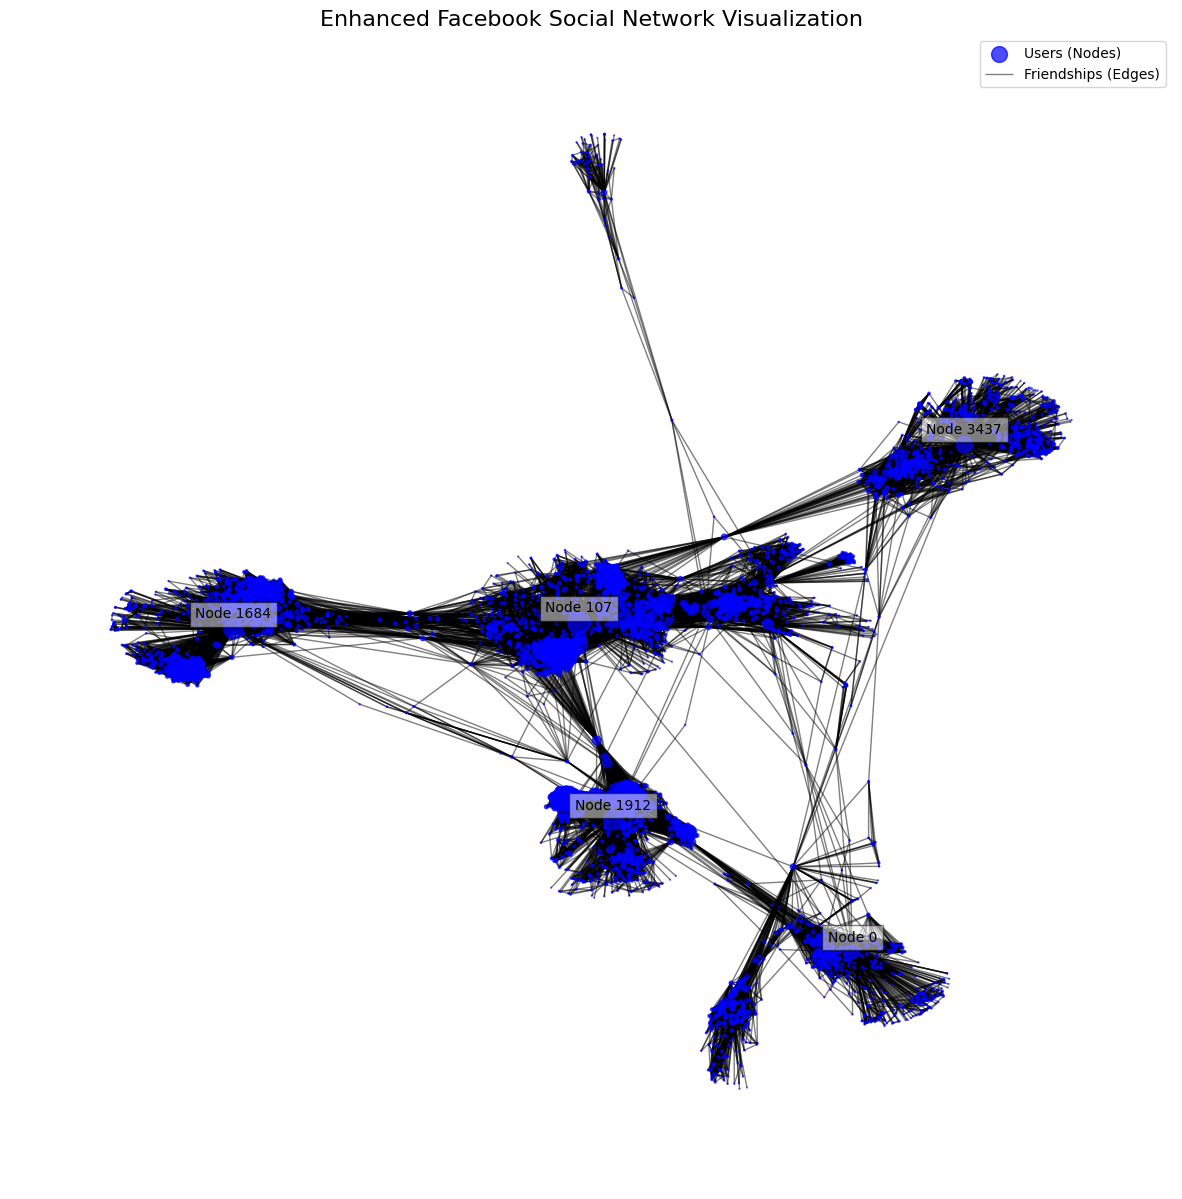

In [ ]:
# Enhanced Visualization with Labels and Scaling
plt.figure(figsize=(15, 15))

# Compute degree centrality for scaling node size
degree_centrality = nx.degree_centrality(G)

# Scale node size by degree centrality
node_sizes = [v * 1000 for v in degree_centrality.values()]

# Draw the graph with node labels for high-degree nodes
pos = nx.spring_layout(G)  # Spring layout for better separation of clusters

# Draw nodes with sizes and colors based on degree centrality
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue", alpha=0.7, label="Users (Nodes)")
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="black", label="Friendships (Edges)")

# Annotate high-degree nodes (e.g., top 5 by degree centrality)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for node, centrality in top_nodes:
    x, y = pos[node]
    plt.text(x, y + 0.02, s=f"Node {node}", fontsize=10, ha="center", bbox=dict(facecolor='white', alpha=0.5))

# Add title, legend, and scale
plt.title("Enhanced Facebook Social Network Visualization", fontsize=16)
plt.legend(loc="best")
plt.axis("off")  # Turn off axes for clarity

# Show the plot
plt.show()


In [ ]:
# Step 6: Save and Download the Processed Graph
import pickle
from google.colab import files

# Save the processed graph using the pickle module
output_file = "processed_facebook_graph.gpickle"
with open(output_file, "wb") as f:
    pickle.dump(G, f)

# Confirm the file is saved
print(f"Processed graph successfully saved as '{output_file}'.")

# Provide a download link for the saved graph
files.download(output_file)


Processed graph successfully saved as 'processed_facebook_graph.gpickle'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#stage2

In [ ]:
import networkx as nx
import random

# Step 1: Clean the Graph
def clean_graph(graph):
    # Remove self-loops
    graph.remove_edges_from(nx.selfloop_edges(graph))

    # Remove isolated nodes
    graph.remove_nodes_from(list(nx.isolates(graph)))

    # Print summary after cleaning
    print(f"Graph cleaned: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges.")
    return graph



In [ ]:
# Step 2: Check Graph Connectivity
def ensure_connectivity(graph):
    if nx.is_connected(graph):
        print("Graph is fully connected.")
    else:
        # Get the largest connected component
        largest_cc = max(nx.connected_components(graph), key=len)
        graph = graph.subgraph(largest_cc).copy()
        print(f"Graph is not connected. Extracted the largest connected component with {graph.number_of_nodes()} nodes.")
    return graph



In [ ]:
import pickle

# Reload the processed graph
with open("processed_facebook_graph.gpickle", "rb") as f:
    G_connected = pickle.load(f)
print("Graph reloaded successfully.")


Graph reloaded successfully.


In [ ]:
def progressive_split_graph(graph, test_ratio=0.05, seed=42):
    random.seed(seed)
    edges = list(graph.edges())
    num_test_edges = int(len(edges) * test_ratio)

    # Step 1: Identify bridge edges
    bridges = list(nx.bridges(graph))
    non_bridge_edges = [edge for edge in edges if edge not in bridges]
    print(f"Number of bridge edges (cannot be removed): {len(bridges)}")
    print(f"Number of non-bridge edges (eligible for test set): {len(non_bridge_edges)}")

    if len(non_bridge_edges) < num_test_edges:
        print("Not enough non-bridge edges to create the test set. Reduce test_ratio or adjust graph.")
        return graph, []

    # Step 2: Initialize test edge set
    test_edges = []
    training_graph = graph.copy()

    # Step 3: Incrementally remove edges
    for edge in random.sample(non_bridge_edges, len(non_bridge_edges)):
        if len(test_edges) >= num_test_edges:
            break

        # Remove the edge and check connectivity
        training_graph.remove_edge(*edge)
        if nx.is_connected(training_graph):
            test_edges.append(edge)
        else:
            # Add the edge back if it disconnects the graph
            training_graph.add_edge(*edge)

    print(f"Split graph into training ({training_graph.number_of_edges()} edges) and test ({len(test_edges)} edges) sets.")
    return training_graph, test_edges

# Call the function with a smaller test ratio
G_train, test_edges = progressive_split_graph(G_connected, test_ratio=0.05)

# Summary
print(f"Training Graph: {G_train.number_of_nodes()} nodes, {G_train.number_of_edges()} edges.")
print(f"Number of Test Edges: {len(test_edges)}")


Number of bridge edges (cannot be removed): 75
Number of non-bridge edges (eligible for test set): 88159
Split graph into training (83823 edges) and test (4411 edges) sets.
Training Graph: 4039 nodes, 83823 edges.
Number of Test Edges: 4411


In [ ]:
import pandas as pd
import random
import networkx as nx

# Step 1: Generate Negative Samples
def generate_negative_samples(graph, num_samples):
    all_nodes = list(graph.nodes())
    negative_samples = set()

    while len(negative_samples) < num_samples:
        node1, node2 = random.sample(all_nodes, 2)
        if not graph.has_edge(node1, node2):  # Ensure the pair is not connected
            negative_samples.add((node1, node2))

    return list(negative_samples)

# Generate negative samples equal to the number of test edges
negative_samples = generate_negative_samples(G_train, len(test_edges))

# Step 2: Compute Features for Node Pairs
def compute_features(graph, node_pairs):
    features = []
    for node1, node2 in node_pairs:
        # Common Neighbors
        common_neighbors = len(list(nx.common_neighbors(graph, node1, node2)))

        # Jaccard Coefficient
        jaccard_coeff = list(nx.jaccard_coefficient(graph, [(node1, node2)]))[0][2]

        # Adamic-Adar Index
        adamic_adar = list(nx.adamic_adar_index(graph, [(node1, node2)]))[0][2]

        # Preferential Attachment
        preferential_attachment = list(nx.preferential_attachment(graph, [(node1, node2)]))[0][2]

        features.append({
            "node1": node1,
            "node2": node2,
            "common_neighbors": common_neighbors,
            "jaccard_coefficient": jaccard_coeff,
            "adamic_adar": adamic_adar,
            "preferential_attachment": preferential_attachment
        })
    return pd.DataFrame(features)

# Compute features for positive samples (test edges)
positive_features = compute_features(G_train, test_edges)
positive_features["label"] = 1  # Label as 1 for positive samples

# Compute features for negative samples
negative_features = compute_features(G_train, negative_samples)
negative_features["label"] = 0  # Label as 0 for negative samples

# Step 3: Combine Positive and Negative Samples
feature_data = pd.concat([positive_features, negative_features], ignore_index=True)

# Save the feature dataset for modeling
feature_data.to_csv("link_prediction_features.csv", index=False)
print("Feature dataset saved as 'link_prediction_features.csv'.")


Feature dataset saved as 'link_prediction_features.csv'.


Logistic Regression:
AUC-ROC Score: 0.9956
F1 Score: 0.9563

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       898
           1       0.98      0.93      0.96       867

    accuracy                           0.96      1765
   macro avg       0.96      0.96      0.96      1765
weighted avg       0.96      0.96      0.96      1765


Logistic Regression Feature Importance:
                   Feature  Importance
2              adamic_adar    7.149487
1      jaccard_coefficient    4.978354
0         common_neighbors   -0.265965
3  preferential_attachment   -0.270951

Random Forest:
AUC-ROC Score: 0.9950
F1 Score: 0.9725

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       898
           1       0.97      0.98      0.97       867

    accuracy                           0.97      1765
   macro avg       0.97      0.97      0.97      1765
we

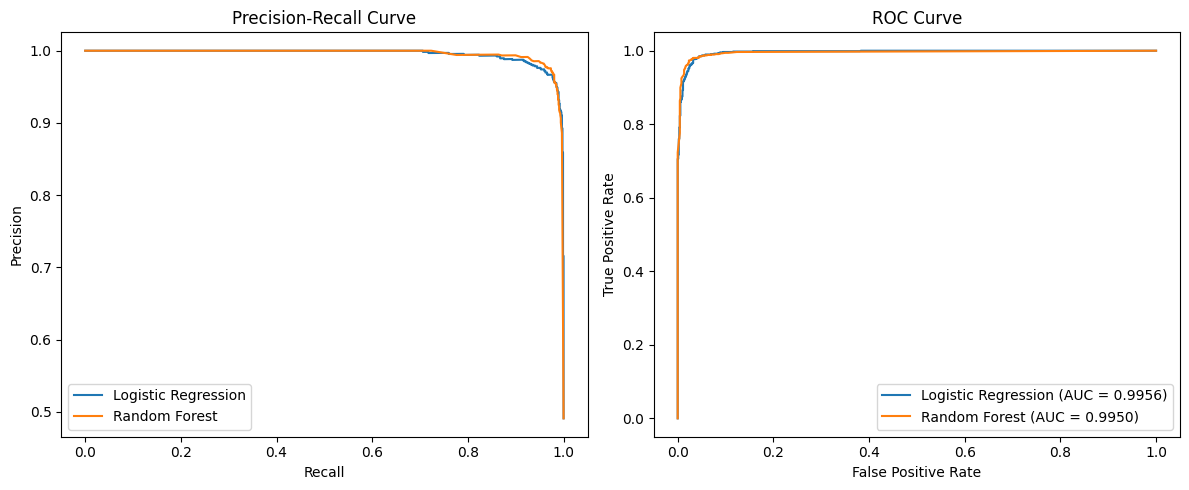

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Step 1: Load the Feature Dataset
data = pd.read_csv("link_prediction_features.csv")

# Separate features and target variable
X = data[["common_neighbors", "jaccard_coefficient", "adamic_adar", "preferential_attachment"]]
y = data["label"]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predictions and probabilities
y_pred_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
y_pred_logreg = logreg.predict(X_test_scaled)

# Evaluate Logistic Regression Model
roc_auc_logreg = roc_auc_score(y_test, y_pred_prob_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
print("Logistic Regression:")
print(f"AUC-ROC Score: {roc_auc_logreg:.4f}")
print(f"F1 Score: {f1_logreg:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

# Feature Importance for Logistic Regression
logreg_feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": logreg.coef_[0]
}).sort_values(by="Importance", ascending=False)
print("\nLogistic Regression Feature Importance:")
print(logreg_feature_importance)

# Step 4: Random Forest Model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions and probabilities
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest Model
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print("\nRandom Forest:")
print(f"AUC-ROC Score: {roc_auc_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature Importance for Random Forest
rf_feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\nRandom Forest Feature Importance:")
print(rf_feature_importance)

# Step 5: Plot Precision-Recall and ROC Curves
plt.figure(figsize=(12, 5))

# Precision-Recall Curve
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_pred_prob_logreg)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_prob_rf)

plt.subplot(1, 2, 1)
plt.plot(recall_logreg, precision_logreg, label="Logistic Regression")
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# ROC Curve
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)

plt.subplot(1, 2, 2)
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {roc_auc_logreg:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
AUC-ROC Score: 0.9957
F1 Score: 0.9690

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       898
           1       0.96      0.97      0.97       867

    accuracy                           0.97      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.97      0.97      0.97      1765


XGBoost Feature Importance:
                   Feature  Importance
2              adamic_adar    0.927862
0         common_neighbors    0.027922
1      jaccard_coefficient    0.027589
3  preferential_attachment    0.016628


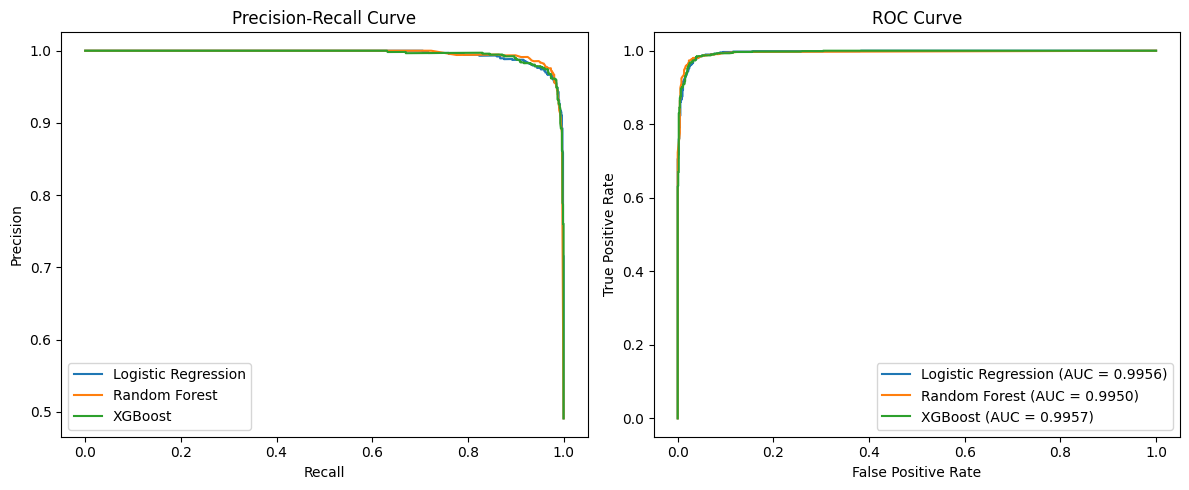

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Step 1: Train XGBoost Classifier
xgb = XGBClassifier(
    use_label_encoder=False,  # Avoids unnecessary warnings
    eval_metric="logloss",   # Metric for classification
    random_state=42
)

xgb.fit(X_train, y_train)

# Step 2: Predictions and Probabilities
y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb.predict(X_test)

# Step 3: Evaluate XGBoost
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print("XGBoost:")
print(f"AUC-ROC Score: {roc_auc_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Feature Importance for XGBoost
xgb_feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\nXGBoost Feature Importance:")
print(xgb_feature_importance)

# Step 4: Plot Precision-Recall and ROC Curves
plt.figure(figsize=(12, 5))

# Precision-Recall Curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_prob_xgb)

plt.subplot(1, 2, 1)
plt.plot(recall_logreg, precision_logreg, label="Logistic Regression")
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.plot(recall_xgb, precision_xgb, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)

plt.subplot(1, 2, 2)
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {roc_auc_logreg:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

# Create the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all CPU cores
)

# Fit the model
grid_search.fit(X_train, y_train)
print("GridSearchCV completed successfully.")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
GridSearchCV completed successfully.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:54:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import joblib

# Save the best estimator from GridSearchCV
joblib.dump(grid_search.best_estimator_, "tuned_xgboost_model.pkl")
print("Tuned XGBoost model saved as 'tuned_xgboost_model.pkl'.")


Tuned XGBoost model saved as 'tuned_xgboost_model.pkl'.


In [ ]:
# Load the saved tuned model
best_xgb = joblib.load("tuned_xgboost_model.pkl")
print("Tuned XGBoost model loaded successfully.")


Tuned XGBoost model loaded successfully.


In [ ]:
import joblib
import pickle
import networkx as nx
import pandas as pd

# Step 1: Load the Tuned XGBoost Model
best_xgb = joblib.load("tuned_xgboost_model.pkl")
print("Tuned XGBoost model loaded successfully.")

# Step 2: Load the Training Graph
with open("processed_facebook_graph.gpickle", "rb") as f:
    G_train = pickle.load(f)
print("Training graph loaded successfully.")

# Step 3: Specify Node Pairs for Prediction
# Replace with actual node pairs or generate random ones
node_pairs_to_predict = [(1, 2), (10, 20), (100, 200)]  # Example node pairs

# Prediction Function
def predict_links(model, graph, node_pairs):
    features = []
    for node1, node2 in node_pairs:
        # Compute features for each node pair
        common_neighbors = len(list(nx.common_neighbors(graph, node1, node2)))
        jaccard_coeff = list(nx.jaccard_coefficient(graph, [(node1, node2)]))[0][2]
        adamic_adar = list(nx.adamic_adar_index(graph, [(node1, node2)]))[0][2]
        preferential_attachment = list(nx.preferential_attachment(graph, [(node1, node2)]))[0][2]

        features.append([common_neighbors, jaccard_coeff, adamic_adar, preferential_attachment])

    # Convert features to DataFrame
    feature_df = pd.DataFrame(features, columns=["common_neighbors", "jaccard_coefficient", "adamic_adar", "preferential_attachment"])

    # Predict probabilities and classes
    probabilities = model.predict_proba(feature_df)[:, 1]  # Probability of the positive class (link exists)
    predictions = model.predict(feature_df)  # Binary predictions (1 for link, 0 for no link)

    # Create a DataFrame with results
    result_df = pd.DataFrame({
        "node1": [pair[0] for pair in node_pairs],
        "node2": [pair[1] for pair in node_pairs],
        "prediction": predictions,
        "probability": probabilities
    })

    return result_df

# Step 4: Predict Links for Node Pairs
predictions = predict_links(best_xgb, G_train, node_pairs_to_predict)
print(predictions)

# Save predictions to CSV
predictions.to_csv("predicted_links.csv", index=False)
print("Predictions saved to 'predicted_links.csv'.")


Tuned XGBoost model loaded successfully.
Training graph loaded successfully.
   node1  node2  prediction  probability
0      1      2           0     0.229566
1     10     20           0     0.229566
2    100    200           1     0.679654
Predictions saved to 'predicted_links.csv'.


In [ ]:
import random
import pickle
import pandas as pd
import networkx as nx

# Step 1: Generate Random Node Pairs
def generate_random_node_pairs(graph, num_pairs=10):
    """
    Generate random, unique node pairs from the graph.

    Parameters:
        graph: The NetworkX graph.
        num_pairs: The number of random node pairs to generate.

    Returns:
        A list of unique (node1, node2) tuples.
    """
    nodes = list(graph.nodes())
    node_pairs = set()  # Use a set to ensure uniqueness

    while len(node_pairs) < num_pairs:
        node1, node2 = random.sample(nodes, 2)  # Randomly select two different nodes
        if not graph.has_edge(node1, node2):  # Ensure the pair is not already connected
            node_pairs.add((node1, node2))

    return list(node_pairs)

# Generate 20 random node pairs
random_node_pairs = generate_random_node_pairs(G_train, num_pairs=20)
print(f"Generated {len(random_node_pairs)} random node pairs:")
print(random_node_pairs)

# Save random node pairs to a file
with open("random_node_pairs.pkl", "wb") as f:
    pickle.dump(random_node_pairs, f)
print("Random node pairs saved to 'random_node_pairs.pkl'.")

# Step 2: Reload Random Node Pairs (Optional)
with open("random_node_pairs.pkl", "rb") as f:
    random_node_pairs = pickle.load(f)
print("Random node pairs reloaded successfully:")
print(random_node_pairs)

# Step 3: Predict Links for Random Node Pairs
def predict_links(model, graph, node_pairs):
    """
    Predict whether links exist between given node pairs using the trained XGBoost model.

    Parameters:
        model: Trained XGBoost model.
        graph: The graph used for feature computation.
        node_pairs: List of (node1, node2) tuples for which to predict links.

    Returns:
        A DataFrame containing predictions and probabilities for each node pair.
    """
    features = []

    # Compute features for each node pair
    for node1, node2 in node_pairs:
        # Compute graph-based features
        common_neighbors = len(list(nx.common_neighbors(graph, node1, node2)))
        jaccard_coeff = list(nx.jaccard_coefficient(graph, [(node1, node2)]))[0][2]
        adamic_adar = list(nx.adamic_adar_index(graph, [(node1, node2)]))[0][2]
        preferential_attachment = list(nx.preferential_attachment(graph, [(node1, node2)]))[0][2]

        # Append features
        features.append([common_neighbors, jaccard_coeff, adamic_adar, preferential_attachment])

    # Convert features to DataFrame
    feature_df = pd.DataFrame(features, columns=["common_neighbors", "jaccard_coefficient", "adamic_adar", "preferential_attachment"])

    # Predict probabilities and classes using the trained model
    probabilities = model.predict_proba(feature_df)[:, 1]  # Probability of the positive class (link exists)
    predictions = model.predict(feature_df)  # Binary predictions (1 for link, 0 for no link)

    # Create a DataFrame with results
    result_df = pd.DataFrame({
        "node1": [pair[0] for pair in node_pairs],
        "node2": [pair[1] for pair in node_pairs],
        "prediction": predictions,
        "probability": probabilities
    })

    return result_df

# Use random node pairs for prediction
predictions = predict_links(best_xgb, G_train, random_node_pairs)

# Display predictions
print(predictions)

# Save predictions to a CSV file
predictions.to_csv("predicted_links_random.csv", index=False)
print("Predictions saved to 'predicted_links_random.csv'.")


Generated 20 random node pairs:
[(3722, 3681), (1453, 1164), (2065, 2262), (3919, 1965), (1507, 3371), (3590, 151), (1109, 1268), (2471, 707), (455, 3004), (1066, 494), (526, 712), (1198, 247), (3400, 2725), (2957, 2784), (1242, 3843), (2309, 427), (1687, 1103), (3668, 2445), (3904, 1358), (1923, 2505)]
Random node pairs saved to 'random_node_pairs.pkl'.
Random node pairs reloaded successfully:
[(3722, 3681), (1453, 1164), (2065, 2262), (3919, 1965), (1507, 3371), (3590, 151), (1109, 1268), (2471, 707), (455, 3004), (1066, 494), (526, 712), (1198, 247), (3400, 2725), (2957, 2784), (1242, 3843), (2309, 427), (1687, 1103), (3668, 2445), (3904, 1358), (1923, 2505)]
    node1  node2  prediction  probability
0    3722   3681           1     0.576029
1    1453   1164           0     0.012357
2    2065   2262           0     0.169683
3    3919   1965           0     0.000732
4    1507   3371           0     0.000794
5    3590    151           0     0.000732
6    1109   1268           0     0.